Install and Import Libraries

In [150]:
# Install required libraries
!pip install numpy pandas torch scikit-learn
!pip install matplotlib seaborn


[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [151]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Load Data

In [152]:
# ----------------------------------------
# Step 1: Read all RV11 Zorro score files
# ----------------------------------------
import os
import pandas as pd
#, "RV20", "RV30", "RV40", "RV50" , "RV12"
def load_balibase_data(base_dir, rv_dirs=["RV11"]):
    data = []
    for rv_dir in rv_dirs:
        # Define the directory path for each RV folder
        rv_folder_dir = os.path.join(base_dir, rv_dir, "fasta_format", "zorro_scores")
        
        # Check if the directory exists
        if os.path.exists(rv_folder_dir):
            for csv_file in os.listdir(rv_folder_dir):
                # Skip files that start with "bbs"
                if csv_file.endswith(".csv") and not csv_file.startswith("bbs"):
                    # Read and append the data from each CSV file
                    df = pd.read_csv(os.path.join(rv_folder_dir, csv_file))
                    data.append(df)
        else:
            print(f"Directory {rv_folder_dir} does not exist.")
    
    # Concatenate all dataframes into one
    return pd.concat(data, ignore_index=True)

# Load data from all specified RV folders
base_dir = "D:/Thesis_MS/DataSet/bb3_release"
data = load_balibase_data(base_dir)

# Check the loaded data (optional)
print(data.head())



   column_index alignment_column  zorro_score
0             1          ----M--     0.000000
1             2          ----K--     0.000000
2             3          ----K--     0.000000
3             4          G---L--     1.099790
4             5          K---K--     1.162091


Preprocess Data

In [153]:
# ----------------------------------------
# Step 2: Preprocess Data
# ----------------------------------------
# Convert alignment_column to numerical features
residues = list("ACDEFGHIKLMNPQRSTVWY-")  # 20 residues + gap
residue_to_idx = {res: idx for idx, res in enumerate(residues)}

def encode_alignment_column(column_str):
    return [residue_to_idx.get(c, 0) for c in column_str.split('-')]

# Encode alignment_column and pad sequences
max_seq_length = max(data['alignment_column'].apply(lambda x: len(x.split('-'))))
X = np.array([encode_alignment_column(col) + [0]*(max_seq_length - len(col.split('-'))) 
              for col in data['alignment_column']], dtype=np.int64)
y = data['zorro_score'].values.astype(np.float32)

# Standardize Zorro scores
scaler = StandardScaler()
y = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Create backward sliding windows
def create_backward_windows(X, window_size=2):
    windows = []
    for i in range(window_size, len(X)):
        window = X[i - window_size : i + 1]  # Current + preceding columns
        windows.append(window)
    return np.array(windows)

window_size = 2  # Current column + 2 preceding
X_windows = create_backward_windows(X, window_size)

# Split into train/validation/test sets
# First split into train and temp
X_temp, X_test, y_temp, y_test = train_test_split(
    X_windows, y[window_size:], test_size=0.2, random_state=42
)

# Then split temp into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: torch.Size([19746, 3, 27])
Validation data shape: torch.Size([4937, 3, 27])
Testing data shape: torch.Size([6171, 3, 27])


Defining LSTM and BILSTm

In [154]:
# ----------------------------------------
# Step 3: Define Fixed LSTM/BiLSTM Models
# ----------------------------------------
class LSTMModel(nn.Module):
    def __init__(self, input_size=21, hidden_size=64, num_layers=1, 
                 window_size=2, max_seq_length=100):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(
            input_size=hidden_size * max_seq_length,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, window_size+1, max_seq_length)
        x = self.embedding(x)  # (bs, ws+1, seq_len, hidden)
        batch_size = x.size(0)
        x = x.view(batch_size, x.size(1), -1)  # (bs, ws+1, seq_len*hidden)
        out, _ = self.lstm(x)  # (bs, ws+1, hidden)
        out = self.fc(out[:, -1, :])  # Use last timestep
        return out.squeeze()

class BiLSTMModel(nn.Module):
    def __init__(self, input_size=21, hidden_size=64, num_layers=1, 
                 window_size=2, max_seq_length=100):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(
            input_size=hidden_size * max_seq_length,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, 1)  # 2x for bidirectional

    def forward(self, x):
        x = self.embedding(x)  # (bs, ws+1, seq_len, hidden)
        batch_size = x.size(0)
        x = x.view(batch_size, x.size(1), -1)  # (bs, ws+1, seq_len*hidden)
        out, _ = self.lstm(x)  # (bs, ws+1, hidden*2)
        out = self.fc(out[:, -1, :])  # Use last timestep
        return out.squeeze()

Training Function

In [155]:
# ----------------------------------------
# Step 4: Training and Evaluation Logic
# ----------------------------------------
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, lr=0.001, patience=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    model.train()
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                # Load best model
                model.load_state_dict(torch.load("best_model.pth"))
                break
    
    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses

Evaluation Function

In [156]:
def evaluate_model(model, X_test, y_test):
    criterion = nn.MSELoss()
    dataset = torch.utils.data.TensorDataset(X_test, y_test)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Calculate metrics
    mse = mean_squared_error(true_labels, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_labels, predictions)
    r2 = r2_score(true_labels, predictions)
    
    # Calculate additional metrics
    mape = np.mean(np.abs((true_labels - predictions) / (true_labels + 1e-8))) * 100
    explained_variance = np.var(predictions) / (np.var(true_labels) + 1e-8)
    
    # Visualizations
    plt.figure(figsize=(15, 10))
    
    # Scatter plot
    plt.subplot(2, 2, 1)
    plt.scatter(true_labels, predictions, alpha=0.5)
    plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Prediction vs True Values')
    
    # Residual plot
    plt.subplot(2, 2, 2)
    residuals = predictions - true_labels
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    # Distribution of residuals
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=50)
    plt.xlabel('Residual Value')
    plt.ylabel('Count')
    plt.title('Distribution of Residuals')
    
    # Q-Q plot
    plt.subplot(2, 2, 4)
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\nModel Evaluation Metrics:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Explained Variance Ratio: {explained_variance:.4f}")
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'explained_variance': explained_variance
    }

Train and Evaluate LSTM


Training LSTM:


Epoch 1/300, Train Loss: 0.5307, Val Loss: 0.4896
Epoch 2/300, Train Loss: 0.4735, Val Loss: 0.4518
Epoch 3/300, Train Loss: 0.4367, Val Loss: 0.4328
Epoch 4/300, Train Loss: 0.4093, Val Loss: 0.4088
Epoch 5/300, Train Loss: 0.3815, Val Loss: 0.3949
Epoch 6/300, Train Loss: 0.3574, Val Loss: 0.3807
Epoch 7/300, Train Loss: 0.3382, Val Loss: 0.3628
Epoch 8/300, Train Loss: 0.3140, Val Loss: 0.3447
Epoch 9/300, Train Loss: 0.2962, Val Loss: 0.3390
Epoch 10/300, Train Loss: 0.2823, Val Loss: 0.3548
Epoch 11/300, Train Loss: 0.2679, Val Loss: 0.3140
Epoch 12/300, Train Loss: 0.2719, Val Loss: 0.3088
Epoch 13/300, Train Loss: 0.2554, Val Loss: 0.2971
Epoch 14/300, Train Loss: 0.2405, Val Loss: 0.2923
Epoch 15/300, Train Loss: 0.2299, Val Loss: 0.2867
Epoch 16/300, Train Loss: 0.2206, Val Loss: 0.2829
Epoch 17/300, Train Loss: 0.2106, Val Loss: 0.2696
Epoch 18/300, Train Loss: 0.2022, Val Loss: 0.2656
Epoch 19/300, Train Loss: 0.1972, Val Loss: 0.2783
Epoch 20/300, Train Loss: 0.1957, Val Lo

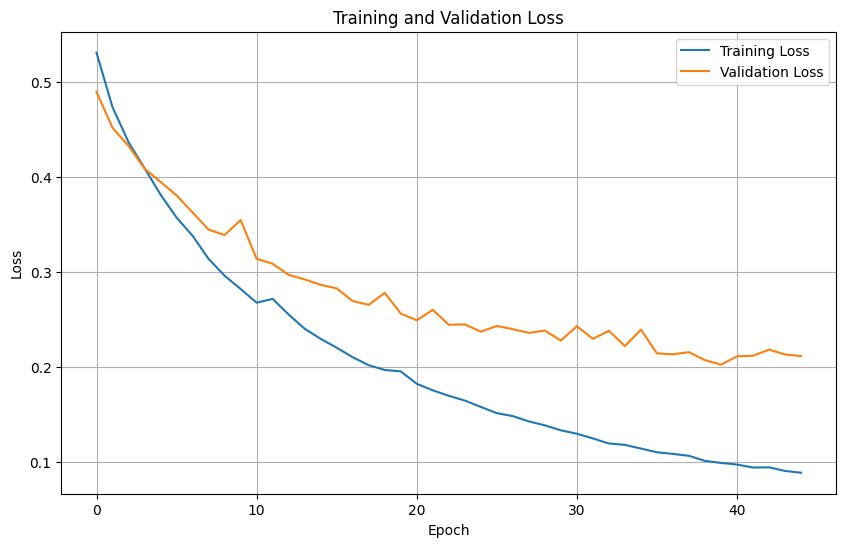


LSTM Evaluation:


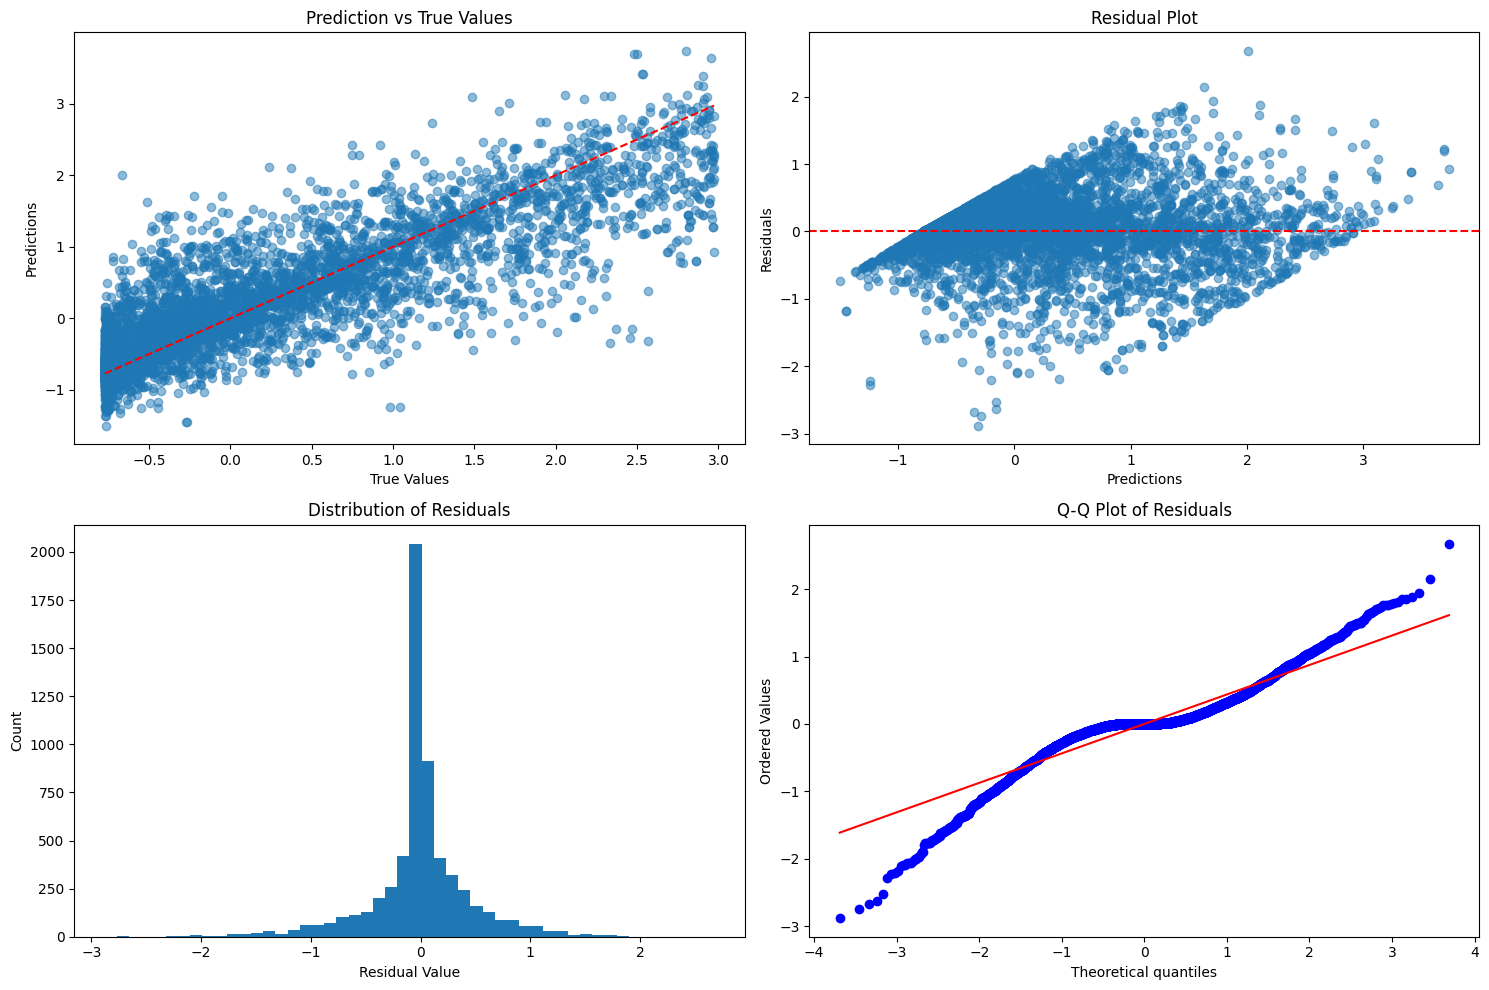


Model Evaluation Metrics:
MSE: 0.2149
RMSE: 0.4636
MAE: 0.2787
R²: 0.7855
MAPE: 307.15%
Explained Variance Ratio: 0.8596


In [157]:
# Get max sequence length from data
max_seq_length = max(data['alignment_column'].apply(lambda x: len(x.split('-'))))

# Initialize models with correct dimensions
lstm_model = LSTMModel(
    input_size=len(residues),
    hidden_size=64,
    window_size=window_size,
    max_seq_length=max_seq_length
).to(device)

# Train LSTM
print("\nTraining LSTM:")
train_losses_lstm, val_losses_lstm = train_model(lstm_model, X_train, y_train, X_val, y_val, epochs=300, patience=5)

# Evaluate LSTM
print("\nLSTM Evaluation:")
lstm_metrics = evaluate_model(lstm_model, X_test, y_test)

# Save model
torch.save(lstm_model.state_dict(), "lstm_model.pth")

Train and Evaluate BiLSTM


Training BiLSTM:
Epoch 1/300, Train Loss: 0.5309, Val Loss: 0.4916
Epoch 2/300, Train Loss: 0.4635, Val Loss: 0.4832
Epoch 3/300, Train Loss: 0.4011, Val Loss: 0.3873
Epoch 4/300, Train Loss: 0.3624, Val Loss: 0.3670
Epoch 5/300, Train Loss: 0.3413, Val Loss: 0.3603
Epoch 6/300, Train Loss: 0.3130, Val Loss: 0.3349
Epoch 7/300, Train Loss: 0.2866, Val Loss: 0.3214
Epoch 8/300, Train Loss: 0.2645, Val Loss: 0.3058
Epoch 9/300, Train Loss: 0.2409, Val Loss: 0.3078
Epoch 10/300, Train Loss: 0.2285, Val Loss: 0.3424
Epoch 11/300, Train Loss: 0.2140, Val Loss: 0.2636
Epoch 12/300, Train Loss: 0.2057, Val Loss: 0.2601
Epoch 13/300, Train Loss: 0.1896, Val Loss: 0.2600
Epoch 14/300, Train Loss: 0.1801, Val Loss: 0.2606
Epoch 15/300, Train Loss: 0.1705, Val Loss: 0.2542
Epoch 16/300, Train Loss: 0.1558, Val Loss: 0.2535
Epoch 17/300, Train Loss: 0.1526, Val Loss: 0.2454
Epoch 18/300, Train Loss: 0.1454, Val Loss: 0.2379
Epoch 19/300, Train Loss: 0.1380, Val Loss: 0.2490
Epoch 20/300, Train Lo

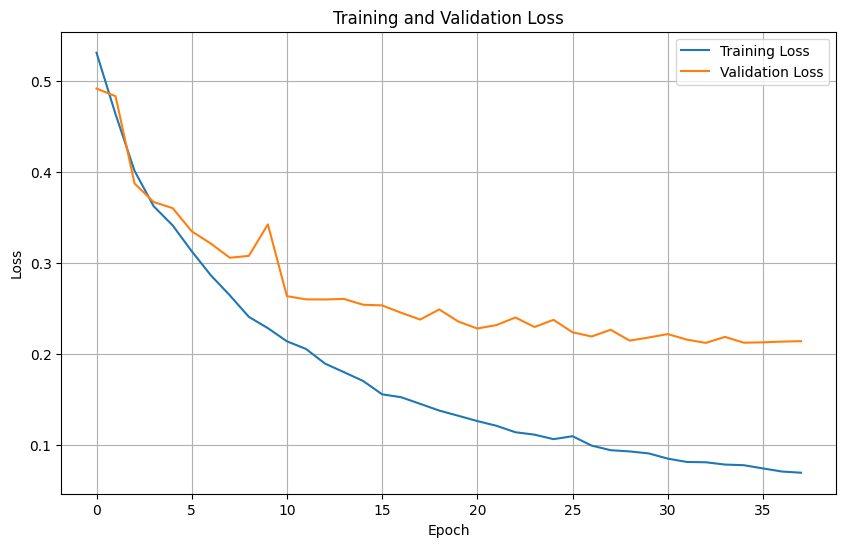


BiLSTM Evaluation:


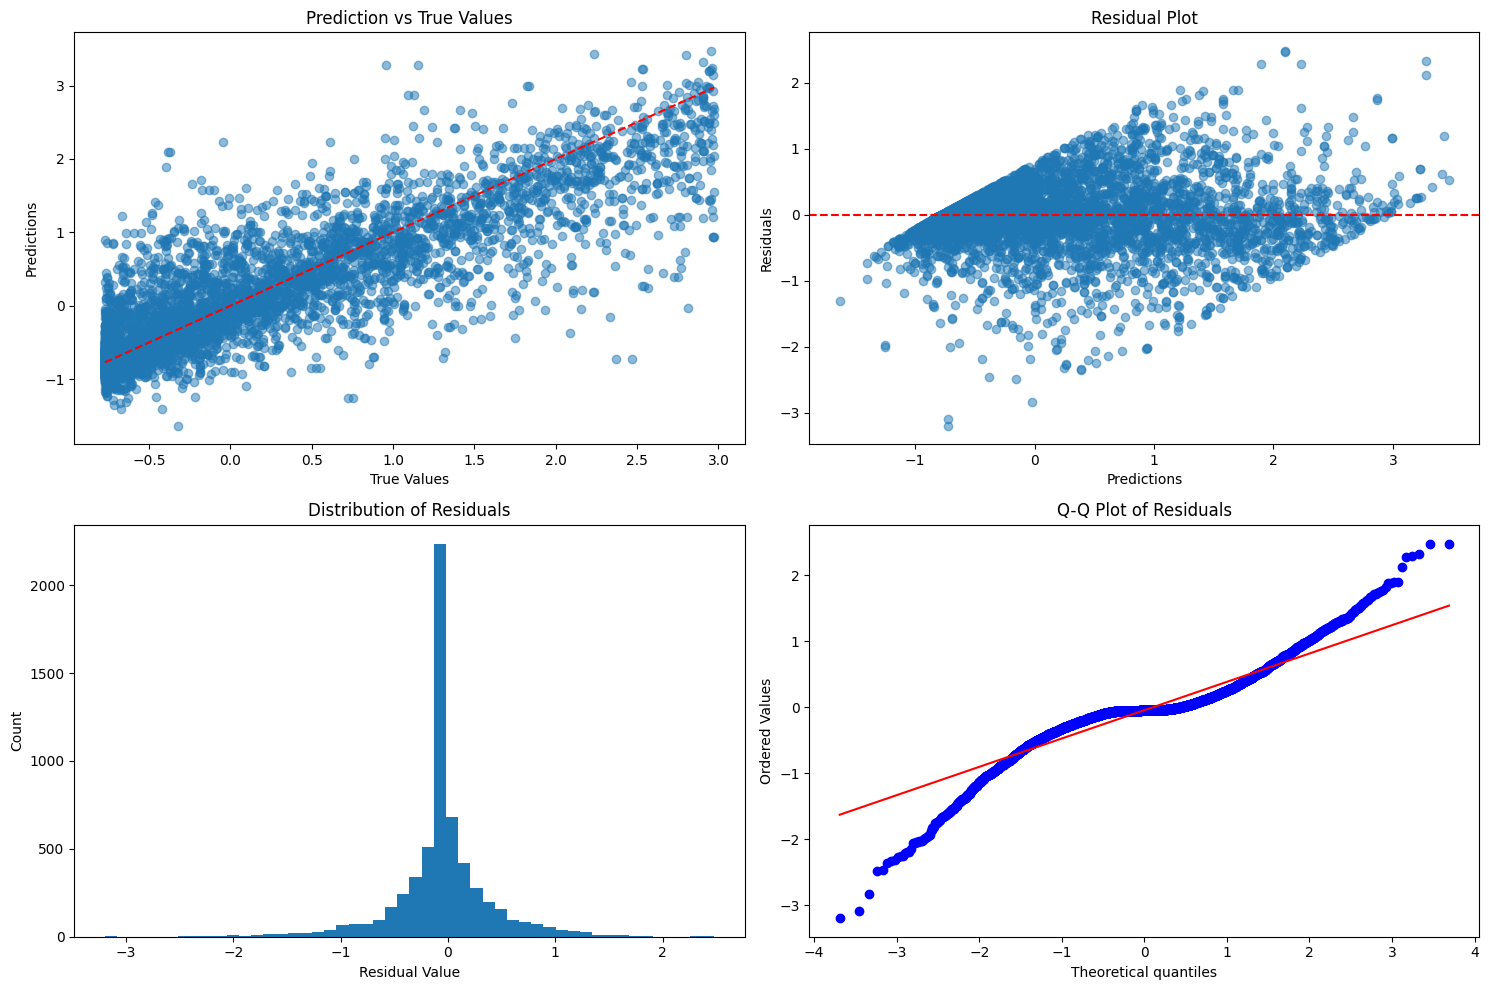


Model Evaluation Metrics:
MSE: 0.2120
RMSE: 0.4604
MAE: 0.2844
R²: 0.7884
MAPE: 172.66%
Explained Variance Ratio: 0.8790

Model Comparison:

Metric		LSTM		BiLSTM
--------------------------------------------------
mse		0.2149		0.2120
rmse		0.4636		0.4604
mae		0.2787		0.2844
r2		0.7855		0.7884
mape		307.1458		172.6591
explained_variance		0.8596		0.8790


In [158]:
# Initialize models with correct dimensions
bilstm_model = BiLSTMModel(
    input_size=len(residues),
    hidden_size=64,
    window_size=window_size,
    max_seq_length=max_seq_length
).to(device)

# Train BiLSTM
print("\nTraining BiLSTM:")
train_losses_bilstm, val_losses_bilstm = train_model(bilstm_model, X_train, y_train, X_val, y_val, epochs=300, patience=5)

# Evaluate BiLSTM
print("\nBiLSTM Evaluation:")
bilstm_metrics = evaluate_model(bilstm_model, X_test, y_test)

# Save model
torch.save(bilstm_model.state_dict(), "bilstm_model.pth")

# Compare models
print("\nModel Comparison:")
metrics = ['mse', 'rmse', 'mae', 'r2', 'mape', 'explained_variance']
print("\nMetric\t\tLSTM\t\tBiLSTM")
print("-" * 50)
for metric in metrics:
    print(f"{metric}\t\t{lstm_metrics[metric]:.4f}\t\t{bilstm_metrics[metric]:.4f}")